What you need to know about wine: 
Question to answer: Can the quality of red wine be accurately predicted using Ph, Alcohol(vol%), residual sugar(g/dm^3) and sulphates(g/dm^3)?
Data set to use:

In [1]:
#code packages
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


.metric  .estimator .estimate
1 accuracy multiclass 0.5400000
2 kap      multiclass 0.2646324

          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   0   0   0
         4   0   0   0   0   0   0
         5   0   4 112  58  12   0
         6   2   7  48  85  20   1
         7   0   0   7  18  19   5
         8   0   0   0   0   2   0

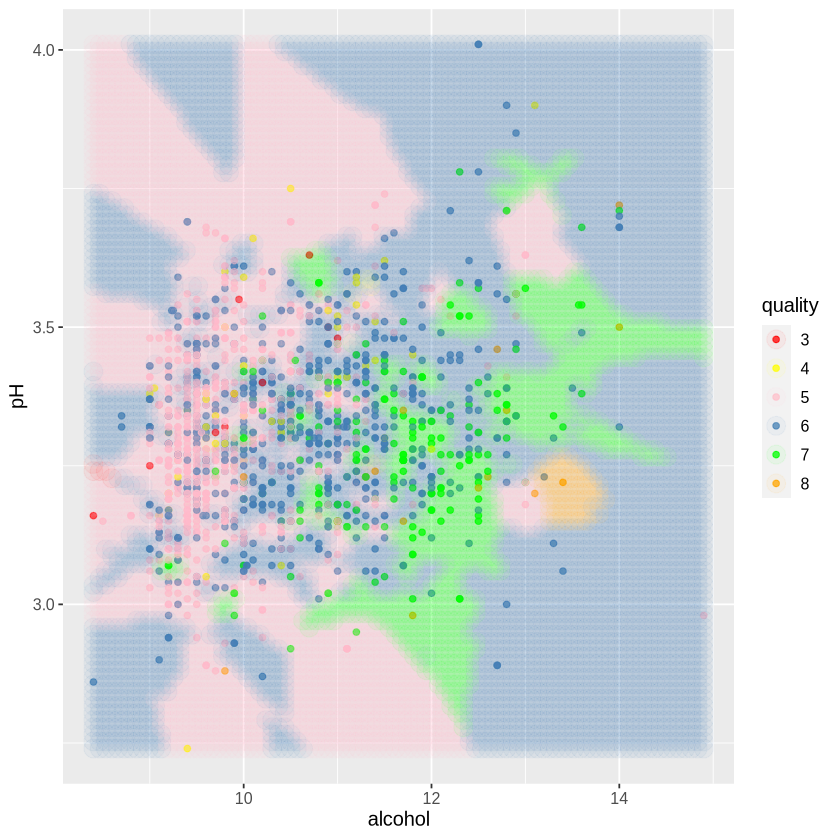

In [2]:
#preliminary data: https://archive.ics.uci.edu/dataset/186/wine+quality

#data
red_wine <- read_delim('data/winequality-red.csv', delim = ';')
red_wine <- red_wine |>
mutate(quality = as_factor(quality))
colnames(red_wine) <- c("fixed_acidity","volatile_acidity","citric_acid","residual_sugar", "chlorides",
"free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality")
# colnames(red_wine)
# head(red_wine)

#general training data
wine_split <- initial_split(red_wine, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)
# wine_train
# wine_test

#choosing random predictors lol, using training data
wine_recipe <- recipe(quality ~ pH + alcohol, data = wine_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())
#wine_recipe

wine_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 5) |>
set_engine('kknn') |>
set_mode('classification')


wine_fit <- workflow() |>
add_recipe(wine_recipe) |>
add_model(wine_spec)|>
fit(data = wine_train)

wine_predict <- predict(wine_fit, wine_test) |>
bind_cols(wine_test)
#wine_predict

wine_accuracy <- wine_predict |>
metrics(truth = quality, estimate = .pred_class)
wine_accuracy

wine_mat <- wine_predict |>
conf_mat(truth = quality, estimate = .pred_class)
wine_mat

#grids
alc_grid <- seq(min(red_wine$alcohol),
                max(red_wine$alcohol),
                length.out = 100)
pH_grid <- seq(min(red_wine$pH),
               max(red_wine$pH),
               length.out = 100)
wine_grid <- as_tibble(expand.grid(alcohol = alc_grid, pH = pH_grid))

#predictions for grid points
grid_preds <- predict(wine_fit, wine_grid)

grid_table <- bind_cols(grid_preds, wine_grid) |>
rename(Class = .pred_class)

#plot
wine_plot <- ggplot() + 
geom_point(data = red_wine, mapping = aes(x = alcohol, y = pH, color = quality), alpha = 0.75) +
geom_point(data = grid_table, mapping = aes(x = alcohol, y = pH, color = Class), alpha = 0.05, size = 5) + 
labs(color = 'quality', x = 'alcohol', y = 'pH') +
scale_color_manual(values = c("red", "yellow", "pink", "steelblue", "green", "orange")) +
theme(text = element_text(size = 12))
wine_plot

methods:

expected outcome and significance: